# Traditional Machine Learning

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

In [3]:
sw_indo = stopwords.words("indonesian")

## Import Data

In [4]:
df = pd.read_csv("data/gojek_review_sentiment.csv")
df.head()

,review,rate
0,Apa aplikasi yang bagus untuk dengan mudah per...,positive
1,Aplikasi ini banyak membantu saya. Sekarang sa...,positive
2,Mengerikan. Antarmukanya sangat membingungkan....,negative
3,Aplikasi yang cukup mengesankan. Butuh waktu l...,positive
4,Aplikasi ini sebenarnya bagus dan sangat memba...,positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1782 non-null   object
 1   rate    1782 non-null   object
dtypes: object(2)
memory usage: 28.0+ KB


In [6]:
df.rate.value_counts()

negative    1061
positive     721
Name: rate, dtype: int64

## Preprocessing

In [7]:
df.review = df.review.str.lower().str.replace(f"[{punctuation}]", "", regex=True).str.replace("\d", "", regex=True)

In [8]:
tokens = []

for text in df.review:
  tokens.append(word_tokenize(text))

df["review"] = tokens
df["review"] = df["review"].apply(lambda x: " ".join([word for word in x if word not in (sw_indo)]))

In [9]:
df.to_csv("data/gojek_sentiment.csv", index=None)

## Dataset Splitting

In [10]:
X = df.review
y = df.rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1425,), (357,), (1425,), (357,))

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer()),
    ('algo', SVC(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 49 candidates, totalling 196 fits
{'algo__C': 10.0, 'algo__gamma': 1.0}
1.0 0.8940314890000944 0.9019607843137255


C:\Users\Achmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## Evaluation

In [14]:
from jcopml.plot import plot_confusion_matrix

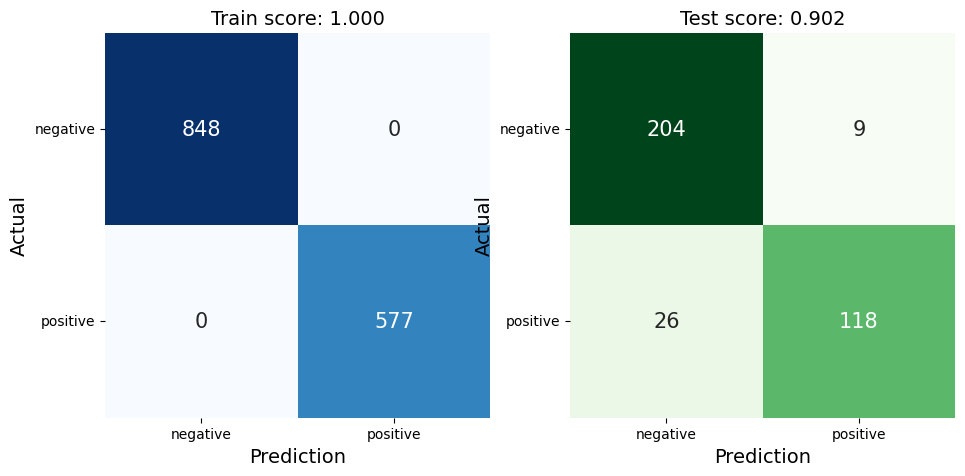

In [15]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Deep Learning

In [16]:
import torch
import torch.nn.functional as F
import torchtext
import time
import random
import pandas as pd

In [17]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 100
EARLY_STOP = 10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

cpu


In [18]:
### Defining the feature processing

tokenize = lambda x: x.split()
    
# Defining Tag and Text
TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=tokenize, lower=True)

### Defining the label processing

LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)

In [19]:
fields = [('TEXT_COLUMN_NAME', TEXT), ('LABEL_COLUMN_NAME', LABEL)]

dataset = torchtext.legacy.data.TabularDataset(
    path='data/gojek_review_sentiment.csv', format='csv',
    skip_header=True, fields=fields)

In [20]:
train_data, test_data = dataset.split(
    split_ratio=[0.9, 0.1],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Test: {len(test_data)}')

Num Train: 1604
Num Test: 178


In [21]:
train_data, valid_data = train_data.split(
    split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Validation: {len(valid_data)}')

Num Train: 1283
Num Validation: 321


In [22]:
print(vars(train_data.examples[0]))

{'TEXT_COLUMN_NAME': ['selama', 'saya', 'menggunakan', 'go', 'jek', 'atau', 'pergi', 'mobil', 'semuanya', 'berjalan', 'dengan', 'baik.'], 'LABEL_COLUMN_NAME': 'negative'}


In [23]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 3923
Number of classes: 2


In [24]:
print(TEXT.vocab.freqs.most_common(20))

[('saya', 1193), ('tidak', 892), ('dan', 678), ('aplikasi', 671), ('yang', 658), ('untuk', 536), ('ini', 351), ('sangat', 331), ('dapat', 294), ('dengan', 266), ('di', 240), ('tetapi', 214), ('lebih', 211), ('anda', 190), ('menggunakan', 176), ('banyak', 168), ('itu', 162), ('bisa', 161), ('ada', 155), ('dari', 153)]


In [25]:
print(TEXT.vocab.itos[:10]) # itos = integer-to-string

['<unk>', '<pad>', 'saya', 'tidak', 'dan', 'aplikasi', 'yang', 'untuk', 'ini', 'sangat']


In [26]:
print(TEXT.vocab.stoi['saya']) # stoi = string-to-integer

2


In [27]:
print(LABEL.vocab.stoi)

defaultdict(None, {'negative': 0, 'positive': 1})


In [28]:
LABEL.vocab.freqs

Counter({'negative': 781, 'positive': 502})

In [29]:
train_loader, valid_loader, test_loader = \
    torchtext.legacy.data.BucketIterator.splits(
        (train_data, valid_data, test_data),
         batch_size=BATCH_SIZE,
         sort_within_batch=False,
         sort_key=lambda x: len(x.TEXT_COLUMN_NAME),
         device=DEVICE
)

In [30]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break
    
print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break
    
print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

Train
Text matrix size: torch.Size([42, 32])
Target vector size: torch.Size([32])

Valid:
Text matrix size: torch.Size([6, 32])
Target vector size: torch.Size([32])

Test:
Text matrix size: torch.Size([7, 32])
Target vector size: torch.Size([32])


In [31]:
class RNN(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        #self.rnn = torch.nn.RNN(embedding_dim,
        #                        hidden_dim,
        #                        nonlinearity='relu')
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, text):
        # text dim: [sentence length, batch size]
        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.fc(hidden)
        return output

In [32]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
from tqdm.auto import tqdm

In [33]:
torch.manual_seed(RANDOM_SEED)
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES # could use 1 for binary classification
)

config = {"batch_size": BATCH_SIZE}

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
callback = Callback(model, config, outdir="model", early_stop_patience=EARLY_STOP, plot_every=100)

In [34]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title(), leave=False):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.0160 | Test_cost  = 0.5389 | Train_score = 0.6072 | Test_score = 0.5763 |


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 1.0166 | Test_cost  = 0.5453 | Train_score = 0.6080 | Test_score = 0.5794 |


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.0199 | Test_cost  = 0.5149 | Train_score = 0.6087 | Test_score = 0.5732 |
==> EarlyStop patience =  1 | Best test_score: 0.5794


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1.0189 | Test_cost  = 0.5407 | Train_score = 0.5892 | Test_score = 0.6012 |


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1.0010 | Test_cost  = 0.5224 | Train_score = 0.6087 | Test_score = 0.5981 |
==> EarlyStop patience =  1 | Best test_score: 0.6012


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 1.0210 | Test_cost  = 0.4962 | Train_score = 0.6087 | Test_score = 0.5857 |
==> EarlyStop patience =  2 | Best test_score: 0.6012


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.9687 | Test_cost  = 0.4628 | Train_score = 0.6041 | Test_score = 0.6106 |


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.7994 | Test_cost  = 0.4171 | Train_score = 0.7631 | Test_score = 0.8069 |


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.5425 | Test_cost  = 0.3225 | Train_score = 0.8550 | Test_score = 0.8567 |


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4150 | Test_cost  = 0.3607 | Train_score = 0.8995 | Test_score = 0.8474 |
==> EarlyStop patience =  1 | Best test_score: 0.8567


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3254 | Test_cost  = 0.4151 | Train_score = 0.9267 | Test_score = 0.8692 |


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3201 | Test_cost  = 0.2727 | Train_score = 0.9236 | Test_score = 0.8847 |


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2583 | Test_cost  = 0.2651 | Train_score = 0.9439 | Test_score = 0.8723 |
==> EarlyStop patience =  1 | Best test_score: 0.8847


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2110 | Test_cost  = 0.5806 | Train_score = 0.9517 | Test_score = 0.8505 |
==> EarlyStop patience =  2 | Best test_score: 0.8847


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1680 | Test_cost  = 0.4488 | Train_score = 0.9602 | Test_score = 0.8536 |
==> EarlyStop patience =  3 | Best test_score: 0.8847


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1171 | Test_cost  = 0.4137 | Train_score = 0.9797 | Test_score = 0.8598 |
==> EarlyStop patience =  4 | Best test_score: 0.8847


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0966 | Test_cost  = 0.2406 | Train_score = 0.9821 | Test_score = 0.8723 |
==> EarlyStop patience =  5 | Best test_score: 0.8847


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0677 | Test_cost  = 0.2810 | Train_score = 0.9867 | Test_score = 0.8567 |
==> EarlyStop patience =  6 | Best test_score: 0.8847


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0560 | Test_cost  = 0.4247 | Train_score = 0.9906 | Test_score = 0.8754 |
==> EarlyStop patience =  7 | Best test_score: 0.8847


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0473 | Test_cost  = 0.4077 | Train_score = 0.9899 | Test_score = 0.8723 |
==> EarlyStop patience =  8 | Best test_score: 0.8847


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0164 | Test_cost  = 0.4556 | Train_score = 0.9992 | Test_score = 0.8692 |
==> EarlyStop patience =  9 | Best test_score: 0.8847


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Test:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0171 | Test_cost  = 0.5028 | Train_score = 0.9977 | Test_score = 0.8692 |
==> EarlyStop patience = 10 | Best test_score: 0.8847
==> Execute Early Stopping at epoch: 22 | Best test_score: 0.8847
==> Best model is saved at model


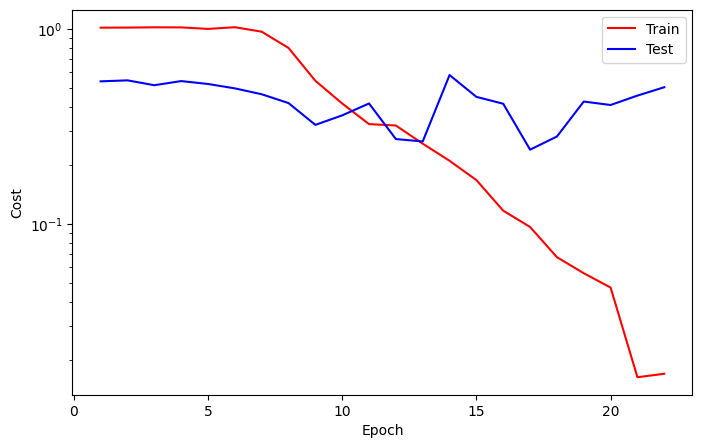

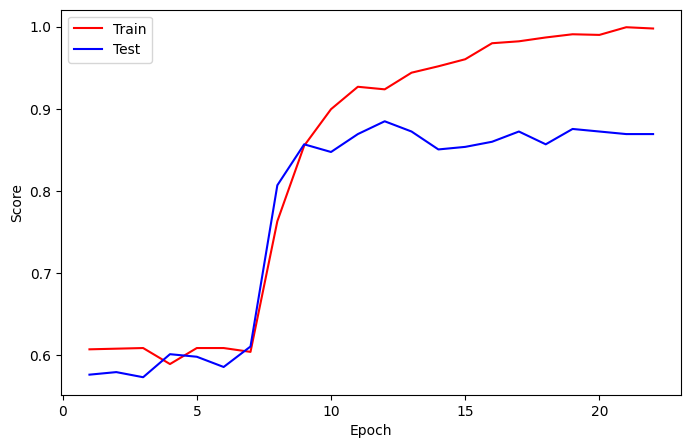

In [35]:
while True:
    train_cost, train_score = loop_fn("train", train_data, train_loader, model, criterion, optimizer, DEVICE)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", valid_data, valid_loader, model, criterion, optimizer, DEVICE)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [36]:
feature, target = next(iter(test_loader))
feature, target = feature.to(DEVICE), target.to(DEVICE)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0])

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [38]:
accuracy = accuracy_score(target, preds)

In [39]:
confusion_matrix(target, preds)

array([[ 6,  0],
       [ 3, 23]], dtype=int64)

In [40]:
print(f"Model deep learning LSTM mendapatkan akurasi sebesar {accuracy*100}% pada data test")

Model deep learning LSTM mendapatkan akurasi sebesar 90.625%
